In [ ]:
pip install stable-baselines3[extra]

In [ ]:
def distribute_miners(self):
    new_miners_loc_x = np.zeros(self.total_miners)
    new_miners_loc_y = np.zeros(self.total_miners)

    for i in range(self.total_miners):
        if np.random.rand() < 0.8:  # 80% chance to stay in the same location
            new_miners_loc_x[i] = self.miners_loc_x[i]
            new_miners_loc_y[i] = self.miners_loc_y[i]
        else:
            # 20% chance to move to a new location based on proximity
            current_x = self.miners_loc_x[i]
            current_y = self.miners_loc_y[i]
            distances = np.sqrt(np.power(self.nodes_loc_x - current_x, 2) + np.power(self.nodes_loc_y - current_y, 2))
            probabilities = 1 / (distances + 1e-10)  # Inverse of distance to create higher probability for closer nodes
            probabilities /= probabilities.sum()  # Normalize to create a probability distribution

            new_node_index = np.random.choice(range(self.nodes), p=probabilities)
            new_miners_loc_x[i] = self.nodes_loc_x[new_node_index]
            new_miners_loc_y[i] = self.nodes_loc_y[new_node_index]

    # Update the miner locations
    self.miners_loc_x = new_miners_loc_x
    self.miners_loc_y = new_miners_loc_y

    # Update the distance matrix
    self.nodes_miners_d = np.zeros((self.nodes, self.miners))
    for k in range(self.nodes):
        for l in range(self.miners):
            self.nodes_miners_d[k][l] = np.sqrt(
                np.float_power((self.nodes_loc_x[k] - self.miners_loc_x[l]), 2) +
                np.float_power((self.nodes_loc_y[k] - self.miners_loc_y[l]), 2))

    # Determine the closest node for each miner
    num_miners_list = np.zeros(self.nodes, dtype=int)
    for l in range(self.miners):
        closest_node = np.argmin(self.nodes_miners_d[:, l])
        num_miners_list[closest_node] += 1

    return num_miners_list


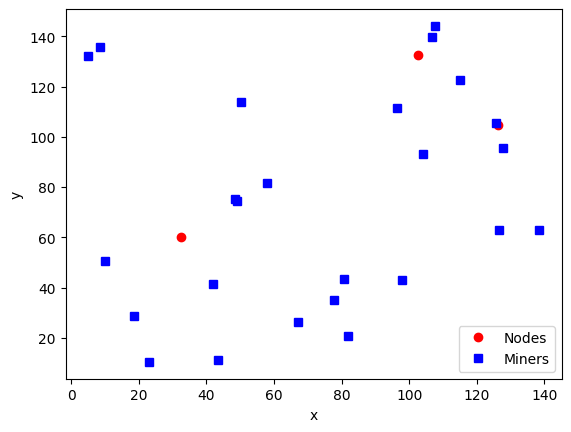

Streaming output truncated to the last 5000 lines.
The total energy consumed is:  4.8e-05
The total energy consumed is:  6e-05
The total energy consumed is:  7.2e-05
The total energy consumed is:  8.400000000000001e-05
The total energy consumed is:  9.6e-05
The total energy consumed is:  0.000108
The total energy consumed is:  0.00011999999999999999
The total energy consumed is:  0.00013199999999999998
The total energy consumed is:  0.00014399999999999998
The total energy consumed is:  0.00015599999999999997
The total energy consumed is:  0.00016799999999999996
The total energy consumed is:  0.00017999999999999996
The total energy consumed is:  0.00019199999999999995
The total energy consumed is:  0.00020399999999999994
The total energy consumed is:  0.00021599999999999994
The total energy consumed is:  0.00022799999999999993
The total energy consumed is:  0.00023999999999999992
The total energy consumed is:  0.00025199999999999995
The total energy consumed is:  0.00026399999999999997


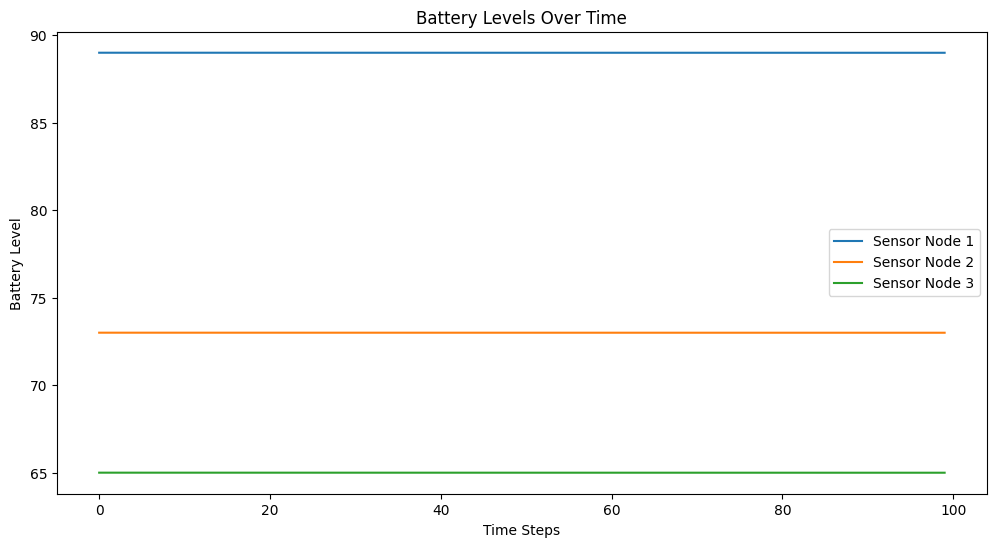

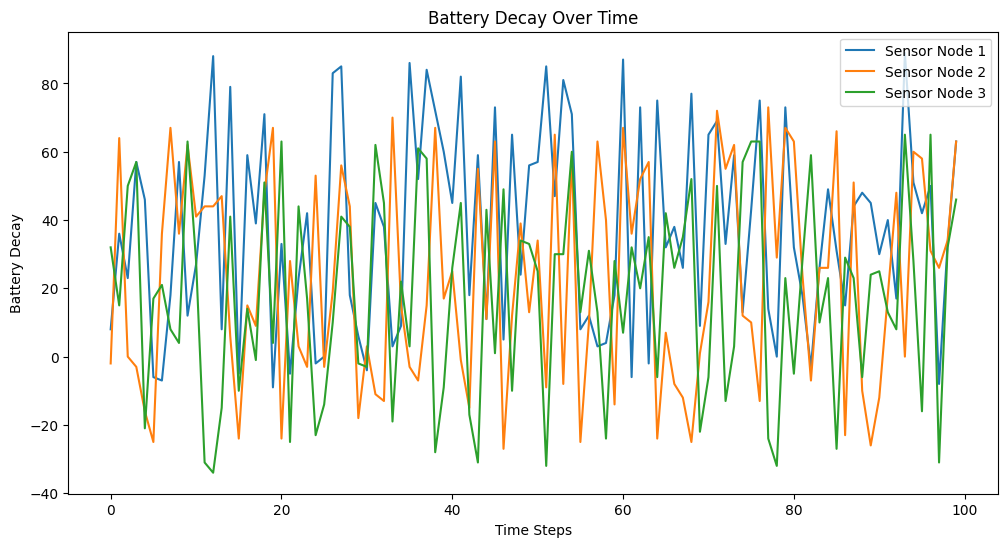

In [1]:
### Just a demo to check the miners location distribution and changes in the battrey levels
import math
import gym
import numpy as np
import matplotlib.pyplot as plt

class MineEnvironment(gym.Env):
    def __init__(self, initial_battery_levels, total_miners):
        super(MineEnvironment, self).__init__()

        self.initial_battery_levels = initial_battery_levels
        self.actual_battery_levels = initial_battery_levels.copy()
        self.num_sensor_nodes = len(initial_battery_levels)
        self.total_miners = total_miners

        self.predicted_battery_levels = np.random.choice(100, self.num_sensor_nodes)
        self.battery_change = np.zeros_like(self.initial_battery_levels)

        self.action_space = gym.spaces.MultiDiscrete([101] * self.num_sensor_nodes)
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(self.num_sensor_nodes, 3), dtype=np.float32)

        self.abl = initial_battery_levels.copy()
        self.pdl = self.predicted_battery_levels.copy()

        self.action_array = np.empty((0, self.num_sensor_nodes))
        self.reward_list = []
        self.error = []
        self.runtime = 0

        self.miners_loc_x = np.zeros(self.total_miners)
        self.miners_loc_y = np.zeros(self.total_miners)
        self.build_location(self.num_sensor_nodes, total_miners)
        self.num_miners_list = self.distribute_miners()

    def build_location(self, nodes, miners):
        self.nodes = nodes
        self.miners = miners
        self.nodes_loc_x = np.random.uniform(0, 150, self.nodes)
        self.nodes_loc_y = np.random.uniform(0, 150, self.nodes)
        self.miners_loc_x = np.random.uniform(0, 150, self.miners)
        self.miners_loc_y = np.random.uniform(0, 150, self.miners)

        self.nodes_miners_d = np.zeros((self.nodes, self.miners))
        for k in range(self.nodes):
            for l in range(self.miners):
                self.nodes_miners_d[k][l] = np.sqrt(
                    np.float_power((self.nodes_loc_x[k] - self.miners_loc_x[l]), 2) +
                    np.float_power((self.nodes_loc_y[k] - self.miners_loc_y[l]), 2))

        plt.plot(self.nodes_loc_x, self.nodes_loc_y, 'ro', label='Nodes')
        plt.plot(self.miners_loc_x, self.miners_loc_y, 'bs', label='Miners')
        plt.legend(loc='lower right')
        plt.ylabel('y')
        plt.xlabel('x')
        plt.show()

    def calculate_energy(self, d):
        k = 240  # Number of bits
        r_c = 80  # Communication range
        epsilon_elec = 50e-9  # Energy to run transmitter/receiver
        epsilon_fs = 10e-12  # Energy for short distance
        epsilon_mp = 0.0013e-12  # Energy for long distance
        d_o = math.sqrt(epsilon_fs / epsilon_mp)
        E_t = 0
        E_r = 0
        if d <= d_o <= r_c:
            E_t = k * epsilon_elec + k * epsilon_fs * d**2
        elif d_o <= d <= r_c:
            E_t = k * epsilon_elec + k * epsilon_mp * d**4
        elif d > r_c:
            E_t = 0
        E_r = k * epsilon_elec
        return E_t, E_r

    def reset(self):
        self.actual_battery_levels = self.initial_battery_levels.copy()
        self.predicted_battery_levels = np.random.choice(100, self.num_sensor_nodes)
        self.num_miners_list = self.distribute_miners()
        self.battery_change = np.zeros_like(self.initial_battery_levels)
        return self.get_state()

    def step(self, action):
        self.runtime += 1
        if self.runtime % 5000 == 0:
            self.num_miners_list = self.distribute_miners()
        self.take_action(action)
        self.abl = np.column_stack((self.abl, self.actual_battery_levels))
        self.pdl = np.column_stack((self.pdl, self.predicted_battery_levels))
        state = self.get_state()
        reward = self.get_reward()
        self.reward_list.append(reward)
        done = False
        info = {}
        return state, reward, done, info

    def get_state(self):
        state = np.column_stack((self.actual_battery_levels, self.num_miners_list, self.battery_change))
        return state

    def distribute_miners(self):
        new_miners_loc_x = np.zeros(self.total_miners)
        new_miners_loc_y = np.zeros(self.total_miners)

        for i in range(self.total_miners):
            if np.random.rand() < 0.5:
                new_miners_loc_x[i] = self.miners_loc_x[i]
                new_miners_loc_y[i] = self.miners_loc_y[i]
            else:
                new_miners_loc_x[i] = np.random.uniform(0, 150)
                new_miners_loc_y[i] = np.random.uniform(0, 150)

        self.miners_loc_x = new_miners_loc_x
        self.miners_loc_y = new_miners_loc_y

        self.nodes_miners_d = np.zeros((self.nodes, self.miners))
        for k in range(self.nodes):
            for l in range(self.miners):
                self.nodes_miners_d[k][l] = np.sqrt(
                    np.float_power((self.nodes_loc_x[k] - self.miners_loc_x[l]), 2) +
                    np.float_power((self.nodes_loc_y[k] - self.miners_loc_y[l]), 2))

        num_miners_list = np.zeros(self.nodes, dtype=int)
        for l in range(self.miners):
            closest_node = np.argmin(self.nodes_miners_d[:, l])
            num_miners_list[closest_node] += 1

        return num_miners_list

    def calculate_battery_decay(self):
        print('Inside battery decay function')
        full_energy = 1000.0
        battery_capacity = 100.0
        for i in range(self.num_sensor_nodes):
            total_energy_consumed = 0
            miners_connected = self.num_miners_list[i]  # Number of miners connected to this sensor node
            for miner_idx in range(self.total_miners):
                if self.num_miners_list[i] > 0:
                    # Only consider miners that are connected to this sensor node
                    d = self.nodes_miners_d[i][miner_idx]
                    E_T, E_R = self.calculate_energy(d)
                    total_energy_consumed += (E_T + E_R)
                    print('The total energy consumed is: ', total_energy_consumed)
            battery_decay = (total_energy_consumed / full_energy) * battery_capacity
            print('The battery decay is: ', battery_decay)
            self.actual_battery_levels[i] -= battery_decay
            self.actual_battery_levels[i] = np.clip(self.actual_battery_levels[i], 0, 100)

    def take_action(self, action):
        self.action_array = np.vstack((self.action_array, action))
        self.predicted_battery_levels = action
        self.predicted_battery_levels = np.clip(self.predicted_battery_levels, 0, 100)
        self.calculate_battery_decay()
        self.battery_change = self.actual_battery_levels - self.predicted_battery_levels
        self.error.append(self.battery_change)

    def get_reward(self):
        B_dt = np.abs(self.actual_battery_levels - self.predicted_battery_levels)
        rewards = [-(b_dt_value * b_dt_value) / 10 for b_dt_value in B_dt]
        return np.sum(rewards) / len(rewards)


# Initialize the parameters
initial_battery_levels = np.array([89.0, 73.0, 65.0])  # Initial battery levels for all sensor nodes
total_miners = 25  # Total number of miners

# Create the custom environment
mine_env = MineEnvironment(initial_battery_levels, total_miners)

# Run a simulation and collect data for plotting
battery_levels_over_time = []
battery_decay_over_time = []

# Number of steps to simulate
steps = 100

for _ in range(steps):
    mine_env.step(mine_env.action_space.sample())
    battery_levels_over_time.append(mine_env.actual_battery_levels.copy())
    battery_decay_over_time.append(mine_env.battery_change.copy())

# Convert to numpy arrays for easier plotting
battery_levels_over_time = np.array(battery_levels_over_time)
battery_decay_over_time = np.array(battery_decay_over_time)

# Plot battery levels over time
plt.figure(figsize=(12, 6))
for i in range(mine_env.num_sensor_nodes):
    plt.plot(battery_levels_over_time[:, i], label=f'Sensor Node {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Battery Level')
plt.title('Battery Levels Over Time')
plt.legend()
plt.show()

# Plot battery decay over time
plt.figure(figsize=(12, 6))
for i in range(mine_env.num_sensor_nodes):
    plt.plot(battery_decay_over_time[:, i], label=f'Sensor Node {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Battery Decay')
plt.title('Battery Decay Over Time')
plt.legend()
plt.show()


In [ ]:
### With previous distribute function
'''
import math
import gym
from stable_baselines3 import PPO
import numpy as np
import matplotlib.pyplot as plt

k = 1000  # Number of bits
r_c = 80  # Communication range
epsilon_elec = 50e-9  # Energy to run transmitter/receiver
epsilon_fs = 10e-12  # Energy for short distance
epsilon_mp = 0.0013e-12  # Energy for long distance

class MineEnvironment(gym.Env):
    def __init__(self, initial_battery_levels, total_miners):
        super(MineEnvironment, self).__init__()

        self.initial_battery_levels = initial_battery_levels
        self.actual_battery_levels = initial_battery_levels.copy()
        self.num_sensor_nodes = len(initial_battery_levels)
        self.total_miners = total_miners

        self.predicted_battery_levels = np.random.choice(100, self.num_sensor_nodes)
        self.num_miners_list = self.distribute_miners(total_miners, self.num_sensor_nodes)
        self.battery_change = np.zeros_like(self.initial_battery_levels)

        self.action_space = gym.spaces.MultiDiscrete([101] * self.num_sensor_nodes)
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(self.num_sensor_nodes, 3), dtype=np.float32)

        self.abl = initial_battery_levels.copy()
        self.pdl = self.predicted_battery_levels.copy()

        self.action_array = np.empty((0, self.num_sensor_nodes))
        self.reward_list = []
        self.error = []
        self.runtime = 0

        self.build_location(self.num_sensor_nodes, total_miners)

    def build_location(self, nodes, miners):
        self.nodes = nodes
        self.miners = miners
        self.nodes_loc_x = np.random.uniform(0, 150, self.nodes)
        self.nodes_loc_y = np.random.uniform(0, 150, self.nodes)
        self.miners_loc_x = np.random.uniform(0, 150, self.miners)
        self.miners_loc_y = np.random.uniform(0, 150, self.miners)

        self.nodes_miners_d = np.zeros((self.nodes, self.miners))
        for k in range(self.nodes):
            for l in range(self.miners):
                self.nodes_miners_d[k][l] = np.sqrt(
                    np.float_power((self.nodes_loc_x[k] - self.miners_loc_x[l]), 2) +
                    np.float_power((self.nodes_loc_y[k] - self.miners_loc_y[l]), 2))

        plt.plot(self.nodes_loc_x, self.nodes_loc_y, 'ro', label='Nodes')
        plt.plot(self.miners_loc_x, self.miners_loc_y, 'bs', label='Miners')
        plt.legend(loc='lower right')
        plt.ylabel('y')
        plt.xlabel('x')
        plt.show()

    def calculate_energy(self, k, d, r_c, epsilon_elec, epsilon_fs, epsilon_mp):
        d_o = math.sqrt(epsilon_fs / epsilon_mp)
        if d <= d_o <= r_c:
            E_t = k * epsilon_elec + k * epsilon_fs * d**2
        elif d_o <= d <= r_c:
            E_t = k * epsilon_elec + k * epsilon_mp * d**4
        elif d > r_c:
            E_t = float('inf')
        else:
            E_t = None
        E_r = k * epsilon_elec
        return E_t, E_r

    def reset(self):
        self.actual_battery_levels = self.initial_battery_levels.copy()
        self.predicted_battery_levels = np.random.choice(100, self.num_sensor_nodes)
        self.num_miners_list = self.distribute_miners(self.total_miners, self.num_sensor_nodes)
        self.battery_change = np.zeros_like(self.initial_battery_levels)
        return self.get_state()

    def step(self, action):
        self.runtime += 1
        if self.runtime % 5000 == 0:
            self.num_miners_list = self.distribute_miners(self.total_miners, self.num_sensor_nodes)
        self.take_action(action)
        self.abl = np.column_stack((self.abl, self.actual_battery_levels))
        self.pdl = np.column_stack((self.pdl, self.predicted_battery_levels))
        state = self.get_state()
        reward = self.get_reward()
        self.reward_list.append(reward)
        done = False
        info = {}
        return state, reward, done, info

    def get_state(self):
        state = np.column_stack((self.actual_battery_levels, self.num_miners_list, self.battery_change))
        return state

    def distribute_miners(self, total_miners, num_nodes):
        num_miners_list = np.zeros(num_nodes, dtype=int)
        for _ in range(total_miners):
            node_index = np.random.randint(num_nodes)
            num_miners_list[node_index] += 1
        return num_miners_list

    def calculate_battery_decay(self):
        full_energy = 10.0  # Full energy in Joules
        battery_capacity = 100.0  # Full battery level in percentage

        for i in range(self.num_sensor_nodes):
            total_energy_consumed = 0
            for miner_idx in range(self.total_miners):
                d = self.nodes_miners_d[i][miner_idx]
                E_t, E_r = self.calculate_energy(k, d, r_c, epsilon_elec, epsilon_fs, epsilon_mp)
                total_energy_consumed += (E_t + E_r)
            battery_decay = (total_energy_consumed / full_energy) * battery_capacity
            self.actual_battery_levels[i] -= battery_decay
            self.actual_battery_levels[i] = np.clip(self.actual_battery_levels[i], 0, 100)

    def take_action(self, action):
        self.action_array = np.vstack((self.action_array, action))
        self.predicted_battery_levels = action
        self.predicted_battery_levels = np.clip(self.predicted_battery_levels, 0, 100)
        self.calculate_battery_decay()
        self.battery_change = self.actual_battery_levels - self.predicted_battery_levels
        self.error.append(self.battery_change)

    def get_reward(self):
        B_dt = np.abs(self.actual_battery_levels - self.predicted_battery_levels)
        rewards = [-(b_dt_value * b_dt_value) / 10 for b_dt_value in B_dt]
        return np.sum(rewards) / len(rewards)


# Initialize the parameters
initial_battery_levels = np.array([89.0, 73.0, 65.0])  # Initial battery levels for all sensor nodes
total_miners = 25  # Total number of miners

# Create the custom environment for multiple sensor nodes
mine_env = MineEnvironment(initial_battery_levels, total_miners)

# Create and train the PPO model
ppo_model = PPO("MlpPolicy", mine_env, verbose=1)
epochs = 2
for epoch in range(epochs):
    mine_env.reset()
    ppo_model.learn(total_timesteps=200000)
'''

'\nimport math\nimport gym\nfrom stable_baselines3 import PPO\nimport numpy as np\nimport matplotlib.pyplot as plt\n\nk = 1000  # Number of bits\nr_c = 80  # Communication range\nepsilon_elec = 50e-9  # Energy to run transmitter/receiver\nepsilon_fs = 10e-12  # Energy for short distance\nepsilon_mp = 0.0013e-12  # Energy for long distance\n\nclass MineEnvironment(gym.Env):\n    def __init__(self, initial_battery_levels, total_miners):\n        super(MineEnvironment, self).__init__()\n\n        self.initial_battery_levels = initial_battery_levels\n        self.actual_battery_levels = initial_battery_levels.copy()\n        self.num_sensor_nodes = len(initial_battery_levels)\n        self.total_miners = total_miners\n\n        self.predicted_battery_levels = np.random.choice(100, self.num_sensor_nodes)\n        self.num_miners_list = self.distribute_miners(total_miners, self.num_sensor_nodes)\n        self.battery_change = np.zeros_like(self.initial_battery_levels)\n\n        self.action_

### Updating the distribute_miners() function

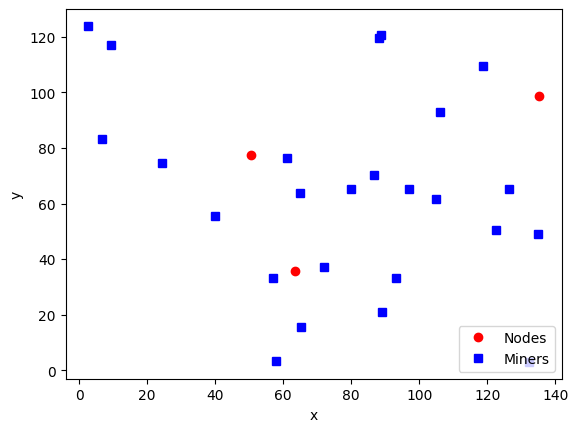

Streaming output truncated to the last 5000 lines.
Inside get_state funciton
The state is:  [[ 0.  7.  0.]
 [ 0.  9. -1.]
 [ 0.  9. -1.]]
Now the reward is:  -0.06666666666666667
The runtime is:  400855
Now the action is:  [2 3 1]
Inside battery_decay function
The change in battery level is:  [-2. -3. -1.]
Inside get_state funciton
The state is:  [[ 0.  7. -2.]
 [ 0.  9. -3.]
 [ 0.  9. -1.]]
Now the reward is:  -0.46666666666666673
The runtime is:  400856
Now the action is:  [4 1 1]
Inside battery_decay function
The change in battery level is:  [-4. -1. -1.]
Inside get_state funciton
The state is:  [[ 0.  7. -4.]
 [ 0.  9. -1.]
 [ 0.  9. -1.]]
Now the reward is:  -0.6000000000000001
The runtime is:  400857
Now the action is:  [4 2 1]
Inside battery_decay function
The change in battery level is:  [-4. -2. -1.]
Inside get_state funciton
The state is:  [[ 0.  7. -4.]
 [ 0.  9. -2.]
 [ 0.  9. -1.]]
Now the reward is:  -0.7000000000000001
The runtime is:  400858
Now the action is:  [0 1 1]


In [ ]:
import math
import gym
from stable_baselines3 import PPO
import numpy as np
import matplotlib.pyplot as plt


class MineEnvironment(gym.Env):
    def __init__(self, initial_battery_levels, total_miners):
        super(MineEnvironment, self).__init__()

        self.initial_battery_levels = initial_battery_levels
        self.actual_battery_levels = initial_battery_levels.copy()
        self.num_sensor_nodes = len(initial_battery_levels)
        self.total_miners = total_miners

        self.predicted_battery_levels = np.random.choice(100, self.num_sensor_nodes)
        #self.num_miners_list = self.distribute_miners()
        self.battery_change = np.zeros_like(self.initial_battery_levels)

        self.action_space = gym.spaces.MultiDiscrete([101] * self.num_sensor_nodes)
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(self.num_sensor_nodes, 3), dtype=np.float32)

        self.abl = initial_battery_levels.copy()
        self.pdl = self.predicted_battery_levels.copy()

        self.action_array = np.empty((0, self.num_sensor_nodes))
        self.reward_list = []
        self.error = []
        self.runtime = 0

        ### Location of the miners
        self.miners_loc_x = np.zeros(self.total_miners)
        self.miners_loc_y = np.zeros(self.total_miners)
        #self.build_location(self.num_sensor_nodes, total_miners)
         #Initialize node and miner locations
        self.build_location(self.num_sensor_nodes, total_miners)
        self.num_miners_list = self.distribute_miners()

    def build_location(self, nodes, miners):
        self.nodes = nodes
        self.miners = miners
        self.nodes_loc_x = np.random.uniform(0, 150, self.nodes)
        self.nodes_loc_y = np.random.uniform(0, 150, self.nodes)
        self.miners_loc_x = np.random.uniform(0, 150, self.miners)
        self.miners_loc_y = np.random.uniform(0, 150, self.miners)

        self.nodes_miners_d = np.zeros((self.nodes, self.miners))
        for k in range(self.nodes):
            for l in range(self.miners):
                self.nodes_miners_d[k][l] = np.sqrt(
                    np.float_power((self.nodes_loc_x[k] - self.miners_loc_x[l]), 2) +
                    np.float_power((self.nodes_loc_y[k] - self.miners_loc_y[l]), 2))

        plt.plot(self.nodes_loc_x, self.nodes_loc_y, 'ro', label='Nodes')
        plt.plot(self.miners_loc_x, self.miners_loc_y, 'bs', label='Miners')
        plt.legend(loc='lower right')
        plt.ylabel('y')
        plt.xlabel('x')
        plt.show()

    def calculate_energy(self, d):

        k = 1000  # Number of bits
        r_c = 80  # Communication range
        epsilon_elec = 50e-9  # Energy to run transmitter/receiver
        epsilon_fs = 10e-12  # Energy for short distance
        epsilon_mp = 0.0013e-12  # Energy for long distance
        d_o = math.sqrt(epsilon_fs / epsilon_mp)
        E_t=0
        E_r=0
        if d <= d_o <= r_c:
            E_t = k * epsilon_elec + k * epsilon_fs * d**2
        elif d_o <= d <= r_c:
            E_t = k * epsilon_elec + k * epsilon_mp * d**4
        elif d > r_c:
            E_t = 0
        E_r = k * epsilon_elec
        return E_t, E_r

    def reset(self):
        self.actual_battery_levels = self.initial_battery_levels.copy()
        self.predicted_battery_levels = np.random.choice(100, self.num_sensor_nodes)
        self.num_miners_list = self.distribute_miners()
        self.battery_change = np.zeros_like(self.initial_battery_levels)
        return self.get_state()

    def step(self, action):
        print('The runtime is: ', self.runtime)
        self.runtime += 1
        if self.runtime % 5000 == 0:
            self.num_miners_list = self.distribute_miners()
        print('Now the action is: ', action)
        self.take_action(action)
        self.abl = np.column_stack((self.abl, self.actual_battery_levels))
        self.pdl = np.column_stack((self.pdl, self.predicted_battery_levels))
        state = self.get_state()
        reward = self.get_reward()
        print('Now the reward is: ', reward)
        self.reward_list.append(reward)
        done = False
        info = {}
        return state, reward, done, info

    def get_state(self):
        print('Inside get_state funciton')
        state = np.column_stack((self.actual_battery_levels, self.num_miners_list, self.battery_change))
        print("The state is: ", state)
        return state

    def distribute_miners(self):
        new_miners_loc_x = np.zeros(self.total_miners)
        new_miners_loc_y = np.zeros(self.total_miners)

        for i in range(self.total_miners):
            if np.random.rand() < 0.5:
                # Miner stays in the same location
                new_miners_loc_x[i] = self.miners_loc_x[i]
                new_miners_loc_y[i] = self.miners_loc_y[i]
            else:
                # Miner moves to a new random location
                new_miners_loc_x[i] = np.random.uniform(0, 150)
                new_miners_loc_y[i] = np.random.uniform(0, 150)

        # Update the miner locations
        self.miners_loc_x = new_miners_loc_x
        self.miners_loc_y = new_miners_loc_y

        # Update the distance matrix
        self.nodes_miners_d = np.zeros((self.nodes, self.miners))
        for k in range(self.nodes):
            for l in range(self.miners):
                self.nodes_miners_d[k][l] = np.sqrt(
                    np.float_power((self.nodes_loc_x[k] - self.miners_loc_x[l]), 2) +
                    np.float_power((self.nodes_loc_y[k] - self.miners_loc_y[l]), 2))

        # Determine the closest node for each miner
        num_miners_list = np.zeros(self.nodes, dtype=int)
        for l in range(self.miners):
            closest_node = np.argmin(self.nodes_miners_d[:, l])
            num_miners_list[closest_node] += 1

        return num_miners_list

    def calculate_battery_decay(self):
        print('Inside battery_decay function')
        full_energy = 10.0  # Full energy in Joules
        battery_capacity = 100.0  # Full battery level in percentage

        for i in range(self.num_sensor_nodes):
            total_energy_consumed = 0
            ### Check this line again
            for miner_idx in range(self.miners):
                d = self.nodes_miners_d[i][miner_idx]
                E_T, E_R = self.calculate_energy( d)
                total_energy_consumed += (E_T + E_R)
            battery_decay = (total_energy_consumed / full_energy) * battery_capacity
            self.actual_battery_levels[i] -= battery_decay
            self.actual_battery_levels[i] = np.clip(self.actual_battery_levels[i], 0, 100)

    def take_action(self, action):
        self.action_array = np.vstack((self.action_array, action))
        self.predicted_battery_levels = action
        self.predicted_battery_levels = np.clip(self.predicted_battery_levels, 0, 100)
        self.calculate_battery_decay()
        self.battery_change = self.actual_battery_levels - self.predicted_battery_levels
        print('The change in battery level is: ', self.battery_change)
        self.error.append(self.battery_change)

    def get_reward(self):
        B_dt = np.abs(self.actual_battery_levels - self.predicted_battery_levels)
        rewards = [-(b_dt_value * b_dt_value) / 10 for b_dt_value in B_dt]
        return np.sum(rewards) / len(rewards)


# Initialize the parameters
initial_battery_levels = np.array([89.0, 73.0, 65.0])  # Initial battery levels for all sensor nodes
total_miners = 25  # Total number of miners

# Create the custom environment for multiple sensor nodes
mine_env = MineEnvironment(initial_battery_levels, total_miners)

# Create and train the PPO model
ppo_model = PPO("MlpPolicy", mine_env, verbose=1)
epochs = 2
for epoch in range(epochs):
    mine_env.reset()
    ppo_model.learn(total_timesteps=200000)


In [ ]:
act_0= mine_env.action_array[0:, :]
act_1= mine_env.action_array[1:, :]
act_2= mine_env.action_array[2:, :]
rew= mine_env.reward_list

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


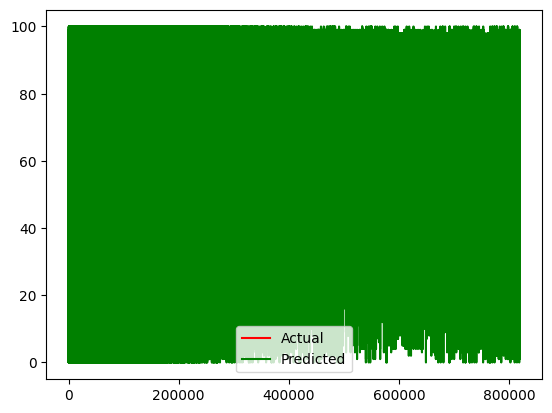

In [ ]:
### Function to print graph
import matplotlib.pyplot as plt
ar_1= mine_env.abl[0,:5000]
ar_2= mine_env.pdl[0, :5000]
ac=ar_1
bl= ar_2
t= np.arange(len(ar_2))
#fig, ax = plt.subplots()
#ax.plot(t, bl)
plt.plot(t, ac, color='r', label='Actual')
#plt.plot(t, bl, color='g', label='Predicted')

#ax.set(xlabel='time_steps', ylabel='battery_level',
       #title='Actual VS Predicted')
plt.legend()
plt.show()

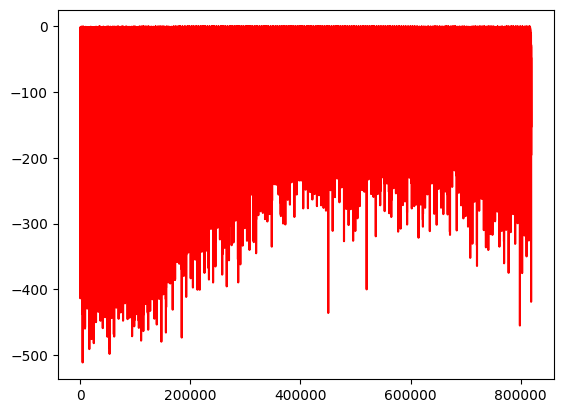

In [ ]:
rew= mine_env.reward_list
rt= np.arange(len(rew))
plt.plot(rt, rew, color='r', label='rewards')